# Projeto CI1030-ERE2: Ciência de Dados
Aqui é apresentado o projeto final para a disciplina CI1030, que consiste na criação de modelos e análise de resultados para os dados de um dataset previamente escolhido.  
O projeto foi desenvolvido visando o uso da ciência de dados para lidar com a detecção de fake news. Logo, o dataset escolhido, posteriormente mencionado, trata-se de um conjunto de notícias (falsas ou não) em português brasileiro.  
Olhando pelo lado da cybersegurança, fortemente abordado na disciplina, considera-se que as fake news estejam relacionadas à área dado que a desinformação promovida por elas pode acabar por ocasionar a criação / facilitar a exploração de vulnerabilidades humanas dentro de sistemas de informação.  
Para a detecção das fake news, considera-se as seguintes 'features' das notícias da database utilizada:

* O `texto` da notícia
* A `classificação` da notícia como verdadeira ou falsa 
* A `categoria` da notícia (política, sociedade...)
* O `número de palavras escritas em letras maiúsculas`
* O `número de verbos no subjuntivo ou no imperativo` utilizados
* A `média do comprimento das sentenças` do texto
* A quantidade de `erros de ortografia` da notícia 


Começa-se por fixar a seed dentro do escopo do projeto, dado que os modelos utilizados envolvam o uso de números aleatórios, para tentar tornar os resultados mais facilmente reprodutíveis.

In [1]:
from sys import exit
import numpy as np

np.random.seed(42)

# Acessando a base de dados
Os dados utilizados neste projeto são provindos de [https://github.com/roneysco/Fake.br-Corpus.git]. Então, para utilizá-los, criou-se o código abaixo para clonar o repositório em questão e 'montar a database'.

Teve-se que 'construir' a base de dados porque, a pesar do diretório disponibilizar um arquivo com os textos pré-processados, a única característica presente é a classificação da notícia como true ou fake. Então, para poder considerar outras características (metadados) das notícias, teve-se que, à mão, mapear as notícias e os metadados desejados para compor o `csv` utilizado.  

Em geral, para o manuseio de dados, utilizou-se a biblioteca `pandas`, `os` e `Git` (para a clonagem).


## Mapeando os dados
O repositório está organizado na seguinte maneira: dentro do diretório 'full_texts', tem-se as pastas 'fake', 'true', 'fake-meta-information', 'true-meta-information'.  
As duas primeiras pastas contêm arquivos com o texto das notícias falsas e verdadeiras, respectivamente.  
As duas últimas pastas, contém as meta-informações das notícias, de forma que o arquivo '1-meta.txt' na pasta 'fake-meta-information' contenha os metadados da noticia '1.txt' da pasta 'fake'.  
O código abaixo faz o mapeamento previamente descrito, ou seja, pega a notícia de um arquivo e, de outro (que contém os respectivos metadados), as informações extras desejadas, para gerar dois csvs, `fake.csv` e `true.csv`, cotendo as notícias e os respectivos metadados.  


In [2]:
import git
import os
import csv
from m_data import M_data

l = ["true", "fake"]
l_number = {"true": 1, "fake": 0}
def populate_data():
    db = "./database/"
    for cat in l:
        with open(db+cat+".csv", "w") as _csv:
            #csv writer instance
            csv_writer = csv.writer(_csv, dialect='unix', quoting=csv.QUOTE_MINIMAL)
            #data header
            data_rows = ["text"
                        ,"label"
                        ,M_data.CATEGORY
                        ,M_data.NUM_WITHOUT_PONCT
                        ,M_data.NUM_UPPERCASE
                        ,M_data.NUM_SUBJ_IMP
                        ,M_data.AVG_SENT_LEN
                        ,M_data.SPEL_ERROR]
            header = [X.name for X in data_rows[2:]]
            header.insert(0, data_rows[0])
            header.insert(1, data_rows[1])
            csv_writer.writerow(header)
            #pwd to construct others
            pwd = "./Fake.br-Corpus/full_texts/" + cat + "/"
            pwd_f = "./Fake.br-Corpus/full_texts/" + cat + "-meta-information/"
            #list of archives on directory
            dir_content = os.listdir(pwd)
            #for each archive
            for archive in dir_content:
                #the meta info of a archive consists of its name + "-meta"
                meta = archive.split(".")
                meta[0] += "-meta"
                meta = ".".join(meta)
                with open(pwd+archive) as data, open(pwd_f+meta) as metadata:
                    a = metadata.readlines()
                    categories = []
                    skip = False
                    for wanted in data_rows[2:]:
                        if not a[wanted.value].strip():
                            skip = True
                        categories.append(a[wanted.value].strip())
                    
                    if not skip:
                        joint = [data.readline().strip()] + [l_number[cat]] + categories
                        joint[0] = str(joint[0])
                        csv_writer.writerow(joint)

## Verificação, clonagem e população

Caso os diretórios do projeto de que pegou-se os dados e da base de dados criada não existam, os processos de clonagem e de população da base de dados serão executados, permitindo que os dois arquivos csvs requisitados sejam carregados posteriormente.



In [3]:

dir_content = os.listdir(os.getcwd())
if not ('Fake.br-Corpus' in dir_content and 'database' in dir_content):
    git.Git("./").clone("https://github.com/roneysco/Fake.br-Corpus.git")
    try:
        os.mkdir("./database")
    except:
        print("failed")
        exit(1)
    populate_data()

## Tratamento dos dados

As notícias são textos (strings), e por isso deve-se tratar esses dados para que o uso de métodos como w2v e tf-idf consigam 'traduzir' o texto de forma efetiva para o processamento. Para isso, seguiu-se os passos explicitados em `https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908`, que consistem em:
* converter todas as letras para maiúsculas ou minúsculas
* remover ou converter números em palavras
* remover pontuações, acentuação dentre outros símbolos
* remover espaçamentos
* tratar abreviações (expandí-las)
* remover palavras vazias, temrmos 'esparsos' e palavras 'particulares'
* canonização

É válido enfatizar que, para as palavras vazias, não encontrou-se alguma listagem 'precisa' para elas. Utilizou-se a listagem de palavras vazias da biblioteca `nltk`, que se trata da tradução de uma lista de 'stopwords' da língua inglesa. Como a classificação de uma palavra como vazia considera-se a semântia, tem-se que essa classificação é específica de língua.

A seguir, está o código que segue alguns dos passos citados anteriormente. Não foram seguidos os passos de expandir abreviações nem de canonização.
A estrutura do código se assemelha à listagem dos processos de tratamento de texto previamente enunciados, aplicando as funções de cada um deles para cada uma das noticias no dataframe. Ao final, cria-se um grande dataframe que contém a database integralmente (junção dos dois arquivos csvs com os textos 'tratados').

In [4]:
import pandas as pd
import re
#remove pontuação
import string
pontuacao = string.punctuation + "”" + "“" + "–"
# stopwords -- preposição, conjunção, determinante / artigo, pronome, adverbio
#palavras do corpus cetemfolha -> mais frequentes são as stopwords
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import unidecode

def process_text(dataf):
    news_text = []
    for sent in dataf['text']:
        #convert all to lower case
        tmp = sent.lower()
        #remove numbers
        tmp = re.sub(r'\d+', '', tmp)
        #remove pontuação
        tmp = tmp.translate(str.maketrans("","",pontuacao))
        #remove acentuação
        tmp = unidecode.unidecode(tmp)
        #remover espaçamento desnecessário
        tmp = tmp.strip()
        #remover palavras vazias
        news_text.append(" ".join([i for i in word_tokenize(tmp) if not i in stopwords]))
    tnews_text = pd.Series(np.array(news_text))
    # true_news_text = np.array([i for i in j for j in true_news_text if not i in stopwords])
    dataf.insert(1,"preprocessed_news", news_text)
    
def create_dataframe(dataframes = []):
    for dataf in dataframes:
        process_text(dataf)
    return pd.concat(dataframes)

d1 = pd.read_csv("./database/true.csv")
d2 = pd.read_csv("./database/fake.csv")

dataframe = create_dataframe([d1, d2])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Dividindo os dados em treino e produção  
Aqui, utiliza-se o métodod `.sample(frac=1)` para embaralhar os dados no dataframe, dado que anteriormente os dados dos arquivos foram unidos com a função 'concatenate' do pandas.  
Tendo os dados embaralhados, a separação em si é efetuada para que 20% dos dados sejam separados para posteriormente simularem um ambiente de produção.

In [5]:
dataframe = dataframe.sample(frac=1)
train_percentage = int(len(dataframe) * 0.8)
training_data, production_data = dataframe[:train_percentage], dataframe[train_percentage:]

## Plotando - Dados de treino e produção  

Segue abaixo o código para plotar a distribuição das categorias entre as porções dos dados. Utiliza-se o pyplot da biblioteca `matplotlib`.  
Representa-se visualmente somente a categorização de 'fake' e 'true' porque os metadados coletados para as notícias serão utilizados para tentar melhorar a  precisão ao classificar uma notícia a pertencer a uma dessas duas categorias.  
Percebe-se que a distribuição foi balanceada. Atribui-se isso à quantidade de notícias falsas e verdadeiras ser a mesma.

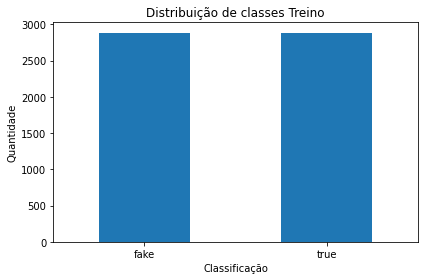

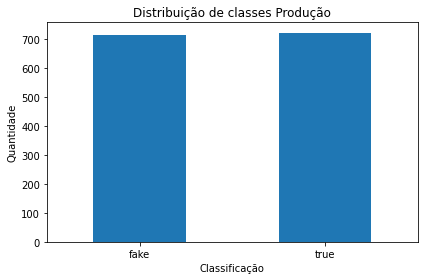

In [6]:
import matplotlib.pyplot as plt

taxa_base = 0
categories = ["Treino", "Produção"]
for clas, cat in zip([training_data, production_data], categories):
    figure, axis = plt.subplots()

    axis = clas['label'].groupby(clas["label"]).count().plot(kind="bar")
    if cat == "Produção":
        taxa_base = clas['label'].groupby(clas["label"]).count()[1] / len(clas)
    axis.set_xlabel("Classificação")
    axis.set_ylabel("Quantidade")
    axis.set_xticklabels(["fake", "true"], rotation='horizontal')
    axis.set_title("Distribuição de classes " + cat)

    figure.tight_layout()
    # plt.savefig("ditribution_"+cat+".pdf")
    plt.show()

# Criação de modelos
Como estão sendo utilizados dados textuais, será utilizado o método tf-idf para a extração das características, e em seguida os valores serão normalizados. Escolheu-se esse método ao invés do 'word to vec' porque em experimentos passados que envolviam o processamento de testo o tf-idf mostrou-se com maior acurácia nos casos abordados. 
Neste ponto, como os dados textuais já foram pré-processados, pode-se partir para a aplicação do tf-idf diretamente.  
Todas as ações abaixo serão efetuadas utilizando recursos da biblioteca `scikit learn`


Separando em conjuntos de treino e teste (somente os 80% do total do dataset)

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test, label_train, label_test = train_test_split(training_data, training_data["label"].values, test_size = 0.2)


* Código utilizado para ter uma ideia da quantidade de palavras que compõe o dataset assim como suas frequências.


In [8]:
vocab = {}
for text in data_train['preprocessed_news']:
    tmp = text.lower().split()
    for palavra in tmp:
        if not palavra in vocab:
            vocab[palavra] = 1
        else:
            vocab[palavra] += 1
print(len(dict((k, v) for k, v in vocab.items() if v <= 1)), len(vocab))

27531 69867


### Extraindo características com o método previamente mencionado  
Separa-se as colunas do dataframe que podem ser excluídas (o texto original e a classificação das notícias como verdadeiras e falsas, dado que seus valores já tenham sido utilizados), as que contém dados textuais para serem convertidos e àquelas com dados numéricos (que podem ser diretamente adicionadas às features)  


In [9]:
DROPPABLE = ['text', 'label']

TEXT_ITTERABLE = ["preprocessed_news", M_data.CATEGORY.name]

NUM_ITERABLE = [M_data.NUM_WITHOUT_PONCT.name
            ,M_data.NUM_UPPERCASE.name
            ,M_data.NUM_SUBJ_IMP.name
            ,M_data.AVG_SENT_LEN.name
            ,M_data.SPEL_ERROR.name]


data_train = data_train.drop(columns=DROPPABLE)
data_test = data_test.drop(columns=DROPPABLE)


* Função que, dados os conjuntos de treino e teste, ajusta o vectorizer conforme os dados de teste fornecidos, e converte os dados de treino e de teste.

In [10]:
def extract_textual(train_data, test_data, vectorizer, isprod = False):
    vectorizer.fit(train_data)
    if not isprod:

        train_features = vectorizer.transform(train_data)
        test_features = vectorizer.transform(test_data)

        return(train_features, test_features)
    else:
        t_features = vectorizer.transform(test_data)

        return t_features

Para a conversão dos dados textuais, utiliza-se o `TfIdfVectorizer` do scikit learn.  
Instancia-se o vectorizer com `max_features = 250` e inicializa-se um vetor de features com os dados numéricos, para que depois possa-se incrementá-los com os dados textuais convertidos.

max features em valores muito altos prejudicam a precisão dos modelos e os transforma, basicamente, em aleatórios.

In [11]:
#TfidfVectorizer = CountVectorizer + TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer
vectorizer = TfidfVectorizer(max_features=250)
#dados numéricos
train_features = data_train[NUM_ITERABLE].values
test_features = data_test[NUM_ITERABLE].values
#dados textuais
for dtext in TEXT_ITTERABLE:
    text_train, text_test = extract_textual(data_train[dtext], data_test[dtext], vectorizer)
    train_features = np.concatenate((train_features, text_train.toarray()), axis=1)
    test_features = np.concatenate((test_features, text_test.toarray()), axis=1)


print(train_features.shape, test_features.shape)


(4608, 261) (1152, 261)


Para a normalização, utiliza-se o MinMaxScaler. Os dados são normalizados após o ajuste do scaler com os dados de treino.


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# data_train_features["preprocessed_news"]
scaler.fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)
print(train_features_norm.shape, test_features_norm.shape)

(4608, 261) (1152, 261)


# Medições - Algoritmos - Porção 'controlada'

Com os dados formatados, pode-se partir enfim para a criação dos modelos. Serão eles, por ordem: KNN, Random Forest e Multilayer Perceptron.  
Primeiramente são apresentadas algumas funções para o manuseio das saídas desejadas.  
Primeiramente efetua-se todas as medições no ambiente de testes para posteriormente ir para o que simula a produção.  
O procedimento em todos os classificadores segue as etapas de: declarar -> ajustar -> fazer uma previsão -> printar os resultados.

* Função que printa o score de precisão dada a equação de precisão em ambiente de produção. Utiliza:
    * Os valores previstos
    * Os valores objetivo
    * A taxa_base do ambiente

In [13]:
def precisão_produção(pred, objective, base_rate):
    true_positive, false_positive = 0, 0
    for res,exp in zip(pred, objective):
        if(res == exp == 1):
            true_positive += 1
        if(res == 1 and res != exp):
            false_positive += 1
    return (true_positive * base_rate) / ((true_positive * base_rate) + (false_positive * (1 - base_rate)))

* Função que printa o score de precisão, média do erro absoluto e a matriz de confusão dados:  
  *  Os valores previstos pela aplicação prévia do classificador
  *  O classificador em si
  *  Os 'objetivos' do classificador
  *  Os dados a serem utilizados como a entrada do classificador  

In [14]:
from sklearn.metrics import precision_score, mean_absolute_error, plot_confusion_matrix
#Funções utilizadas em todas as avaliações dos algoritmos

#Resultados - matriz de confusão, precisão e erro 
def print_results(test_pred, classifier, label, inp, base_rate = 0):
    #Treinamento
    if(base_rate != 0):
        print("Precisão de produção: ", precisão_produção(test_pred, label, base_rate))
    #precisão
    print("Precisão: ", precision_score(label, test_pred))
    #Erro
    print("Erro médio absoluto: ", mean_absolute_error(label, test_pred))
    disp = plot_confusion_matrix(classifier, inp, label, cmap=plt.cm.Blues)
    disp.ax_.set_title("Confusão - KNN")
    plt.show()
        

* Definição de um scorer 'customizado' para tornar possível a construção da matriz de confusão para cada iteração da validação cruzada, posteriormente enunciada. Utiliza-se:
    * O classificador
    * Os dados a serem utilizados como a entrada do classificador
    * Os 'objetivos' do classificador


In [15]:
#Resultados K-folder cross validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0,0], 'fp': cm[0,1], 'fn': cm[1,0], 'tp': cm[1,1]}



* Função para printar os resultados de cada iteração da validação cruzada, utilizando também o scorer previamente enunciado:
    * O classificador
    * Os dados a serem utilizados como a entrada do classificador
    * Os 'objetivos' do classificador


In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def resultados_cv(classifier, x, y):
    cv_precision = cross_val_score(classifier, x, y, cv=5, scoring='precision')
    cv_error = cross_val_score(classifier, x, y, cv=5, scoring='neg_mean_absolute_error')
    cv_result_cm = cross_validate(classifier, x, y, cv=5, scoring=confusion_matrix_scorer)
    cv = cross_validate(classifier, x, y, cv=5, scoring='roc_auc')
    for i in range(5):
        print("Iteração "+str(i)+":")
        print("\tPrecisão cross validation: ", cv_precision[i])
        print("\tErro absoluto médio cross validation: ", cv_error[i]*(-1))
    print("Matrizes: ")
    for i in range(5):
        x = np.array([cv_result_cm['test_tn'][i], cv_result_cm['test_fp'][i]])
        y = np.array([cv_result_cm['test_fn'][i], cv_result_cm['test_tp'][i]])
        arr = np.array([x,y])
        disp = ConfusionMatrixDisplay(confusion_matrix=arr, display_labels=['false','true'])
        disp.plot(cmap=plt.cm.Blues)

* Função para printar a curva ROC dados os resultados da predição de um modelo e os 'objetivos'.

In [17]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, plot_roc_curve
def plot_alg_roc(prediction, label_test):
    
    fpr, tpr, thresholds = roc_curve(label_test, prediction)
    roc_auc = auc(fpr, tpr)
    dsp = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'ROC')
    dsp.plot()

* Função para printar o gráfico composto pelas curvas ROC geradas a cada iteração da validação cruzada. Utiliza:
    * O classificador
    * Os dados de treino
    * Os 'objetivos'
    * A label do modelo sendo utilizado
    * Booleano para saber quando o ambiente não é o de treino

Como o classificador deve ser ajustado, armazena-se em dois dicionários os dados utilizados para treino (entradas e saídas esperadas), para que sejam novamente utilizadas no ambiente de produção e simular o classificador com os dados não-vistos. A label do modelo serve para acessar os dados que tenham sido utilizados no ambiente de testes.

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, plot_roc_curve
#ROC de Cross validation
training_data_sets = {}
training_label_sets = {}
def roc_cv(classifier, train_data, labels, model, isprod = False):
    cv = StratifiedKFold(n_splits = 5)
    tprs = []  
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    fig, ax=plt.subplots()
    for i, (train, test) in enumerate(cv.split(train_data, labels)):
        if not isprod: 
            classifier.fit(train_data[train], labels[train])
            training_data_sets[model] = train_data[train]
            training_label_sets[model] = labels[train]
        else:
            classifier.fit(training_data_sets[model], training_label_sets[model])
        viz = plot_roc_curve(classifier, train_data[test],labels[test], name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0,1], [0,1], linestyle='--', lw=2, color='r', label='Chance',alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)'%(mean_auc, std_auc), lw=2, alpha=.8)

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC para CV")
    ax.legend(loc='lower right')
    plt.show()

## KNN
Utiliza-se a função KNeighborsClassifier da biblioteca scikit learn para efetuar a métrica.
Fez-se um teste com alguns valores para `n` para decidir o ideal. 
Nos testes, percebeu-se que dentre os `n` pequenos o modelo apresentou uma curva ROC que se aproximava da classificação aleatória (linha vermelha no gráfico). Além disso, teve-se que o resultado convergiu com `n` em torno de 45, de forma que os resultados piorassem, caso diminuído, e se mantivessem constantes ou com ganho baixíssimo com o seu aumento.  
Os resultados são mostrados abaixo:

Precisão:  0.5720081135902637
Erro médio absoluto:  0.3732638888888889


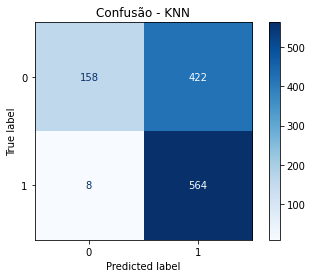

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

neigh = KNeighborsClassifier(n_neighbors=45)

neigh.fit(train_features_norm, label_train)
test_pred_knn = neigh.predict(test_features_norm)

print_results(test_pred_knn,neigh,label_test,test_features_norm)


### Validação e curva ROC - KNN
Abaixo estão os valores da validação do treinamento do modelo KNN, assim como as figuras requisitadas.  
Percebe-se que o treino do modelo, a pesar de ter uma precisão tendendo ao aleatório, costuma apresentar muito poucos falsos negativos (comportamento que se manteve constante durante as testagens de `n`). No entanto, essa 'feature' perde seu peso porque pode-se concluir que o modelo tende a classificar as notícias como verdadeiras em quaisquer circunstâncias. Como o KNN considera a 'vizinhança' do dado para classificá-lo (distância euclidiana entre ele e as outras amostras), considera-se que a grande ocorrência de falsos positivos ocorra por uma tendência no hiperplano gerado pelas 'features' utilizadas de forma que, no geral, as distâncias sejam sempre menores entre o 'dado novo' e àqueles considerados como verdadeiros.

Iteração 0:
	Precisão cross validation:  0.5792922673656619
	Erro absoluto médio cross validation:  0.368763557483731
Iteração 1:
	Precisão cross validation:  0.6375545851528385
	Erro absoluto médio cross validation:  0.2950108459869848
Iteração 2:
	Precisão cross validation:  0.569620253164557
	Erro absoluto médio cross validation:  0.3806941431670282
Iteração 3:
	Precisão cross validation:  0.5841968911917098
	Erro absoluto médio cross validation:  0.35939196525515743
Iteração 4:
	Precisão cross validation:  0.601360544217687
	Erro absoluto médio cross validation:  0.33876221498371334
Matrizes: 


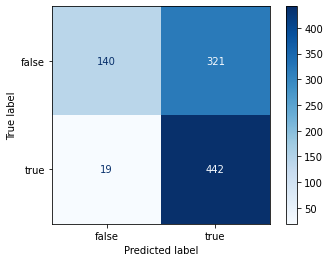

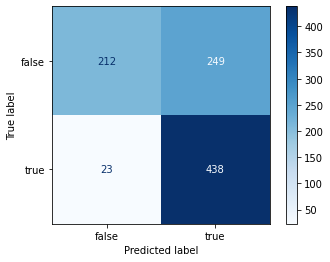

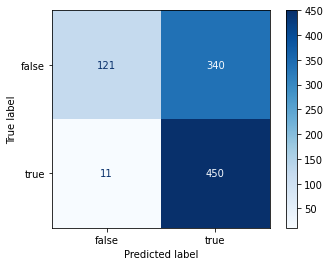

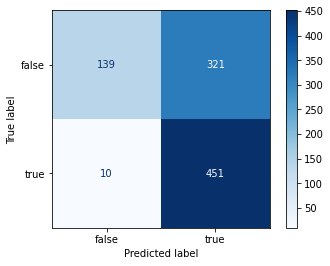

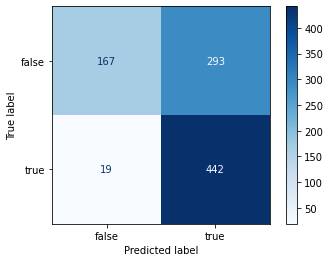

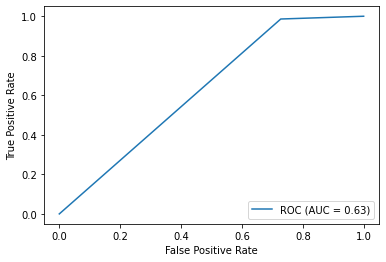

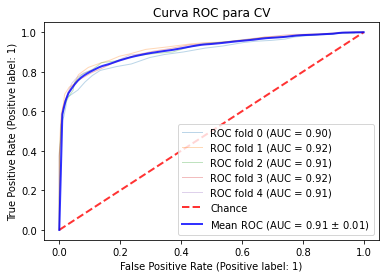

In [20]:
resultados_cv(neigh, train_features_norm, label_train)

plot_alg_roc(test_pred_knn, label_test)

roc_cv(neigh, train_features_norm, np.array(label_train), 'knn')

## Random Forest
Utiliza-se a função RandomForestClassifier da biblioteca scikit learn para efetuar a métrica. Os resultados são mostrados abaixo.  
O valor da precisão converge em torno de 95%, então buscou-se um número de estimadores menor do que o pré-determinado pela biblioteca (inicialmente utilizado) com o intuito de poupar processamento, e assim contornar um dos piores pontos negativos do algoritmo.  
O número de estimadores escolhido foi `20` dado que foi com esse número que o resultado convergiu.

Precisão:  0.946551724137931
Erro médio absoluto:  0.046875


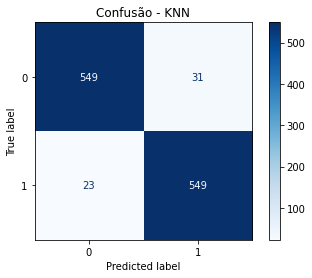

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20)

rfc.fit(train_features_norm, label_train)
test_pred_rfc = rfc.predict(test_features_norm)

print_results(test_pred_rfc, rfc,label_test,test_features_norm)


### Validação e curva ROC - Random Forest
Abaixo estão os valores da validação do treinamento do modelo RF, assim como as figuras requisitadas.  
Diferentemente do KNN, aqui foi apresentada alta precisão e eficácia na classificação proposta, com a curva ROC chegando sendo quase a ideal.  
Atribui-se isso à possibilidade de que o acréscimo de features tenha auxiliado na 'filtragem' das árvores de decisão geradas pelo modelo.

Iteração 0:
	Precisão cross validation:  0.9437229437229437
	Erro absoluto médio cross validation:  0.05422993492407809
Iteração 1:
	Precisão cross validation:  0.9518599562363238
	Erro absoluto médio cross validation:  0.052060737527114966
Iteração 2:
	Precisão cross validation:  0.962882096069869
	Erro absoluto médio cross validation:  0.0368763557483731
Iteração 3:
	Precisão cross validation:  0.9673202614379085
	Erro absoluto médio cross validation:  0.04125950054288816
Iteração 4:
	Precisão cross validation:  0.9368421052631579
	Erro absoluto médio cross validation:  0.0499457111834962
Matrizes: 


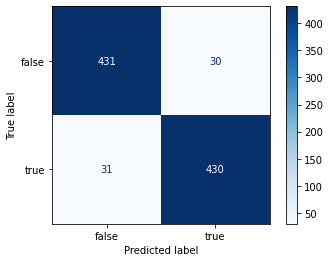

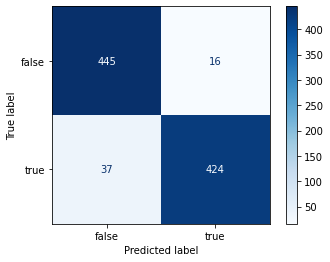

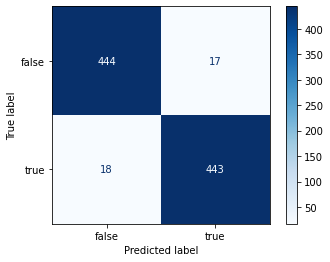

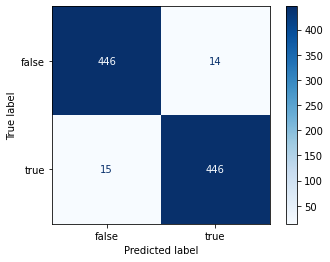

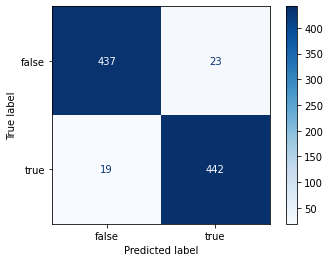

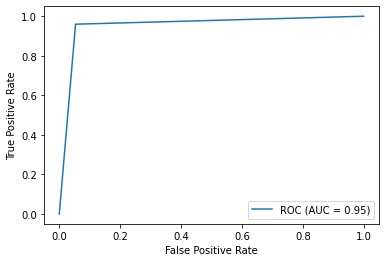

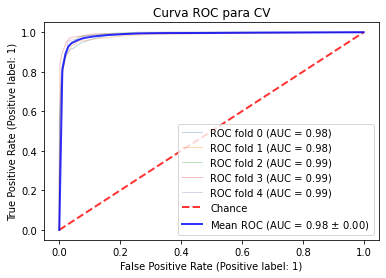

In [22]:
resultados_cv(rfc, train_features_norm, label_train)

plot_alg_roc(test_pred_rfc, label_test)

roc_cv(rfc, train_features_norm, np.array(label_train), 'rfc')

## Multilayer Perceptron Classifier
Utiliza-se a função MLPClassifier da biblioteca scikit learn para efetuar a métrica. Os resultados são mostrados abaixo.  
Como parâmetros, foram alterados o `número máximo de iterações` (de 200 para 300), a taxa de aprendizado `alpha` do modelo (de 0.01% para 0.04%) e atribuiu-se a propriedade `invscaling` para a learning rate (para fazer com que ela reduza conforme o tempo passe para auxiliar na convergência). Utiliza-se uma camada escondida (classificação de um conjunto não-linearmente separável) com `60 neurônios` (valores muito próximos do default da biblioteca, mas com menos unidades).

Precisão:  0.9527145359019265
Erro médio absoluto:  0.04774305555555555


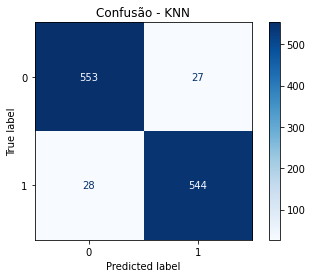

In [23]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes= (60,), max_iter = 300, alpha=0.0004, learning_rate="invscaling")

mlp.fit(train_features_norm, label_train)
test_pred_mlp = mlp.predict(test_features_norm)

print_results(test_pred_mlp, mlp,label_test,test_features_norm)

### Validação e curva ROC - Multilayer Perceptron Classifier
Abaixo estão os valores da validação do treinamento do modelo RF, assim como as figuras requisitadas.  
Assim como no modelo anterior, houve uma alta taxa de precisão e eficácia. Considera-se isso à capacidade que o modelo obteve em separar as notícias verdadeiras das falsas no hiperplano gerado pelas 'features' utilizadas.

Iteração 0:
	Precisão cross validation:  0.9506726457399103
	Erro absoluto médio cross validation:  0.06616052060737528
Iteração 1:
	Precisão cross validation:  0.9405286343612335
	Erro absoluto médio cross validation:  0.06724511930585683
Iteração 2:
	Precisão cross validation:  0.9326086956521739
	Erro absoluto médio cross validation:  0.06724511930585683
Iteração 3:
	Precisão cross validation:  0.9465811965811965
	Erro absoluto médio cross validation:  0.051031487513572206
Iteração 4:
	Precisão cross validation:  0.9509594882729211
	Erro absoluto médio cross validation:  0.053203040173724216
Matrizes: 


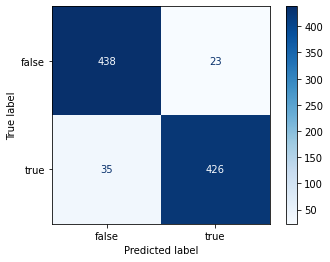

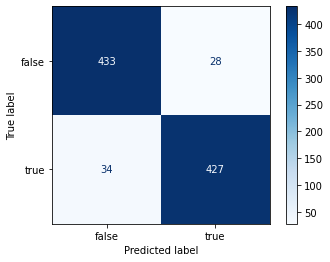

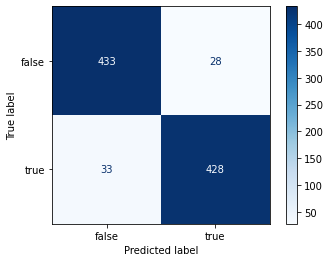

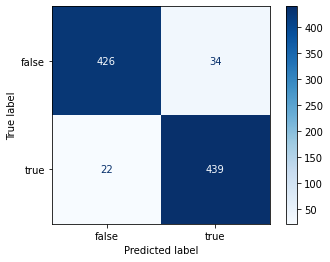

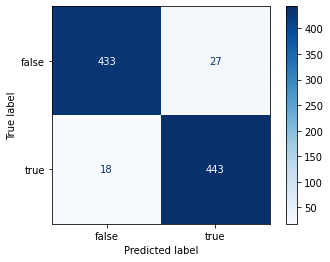

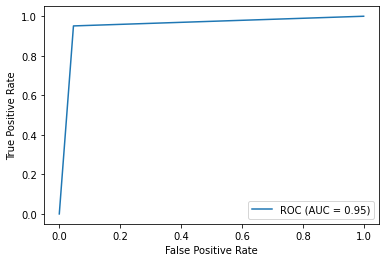

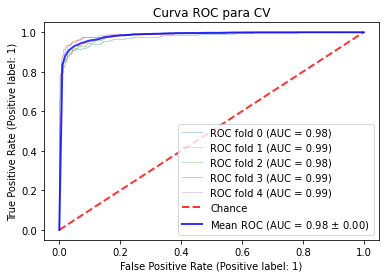

In [24]:
resultados_cv(mlp, train_features_norm, label_train)

plot_alg_roc(test_pred_mlp, label_test)

roc_cv(mlp, train_features_norm, np.array(label_train), 'mlp')

Ao final das medições do treinamento, pode-se afirmar que a classificação das notícias do dataset como verdadeiras e como falsas é efetivamente possível ao utilizar um algoritmo que favoreça a separação.  
Em uma versão anterior, ao se considerar as notícias sem seus metadados, o resultado foi similar àquele previamente apresentado, mas a grande mudança foi quanto à classificação do KNN, que piorou, enquanto os outros dois melhoraram.

# Medições - Algoritmos - Porção 'produção'
A seguir está a segunda parte da execução dos experimentos, mas utilizando os dados separados para simular o ambiente de produção.  
No geral os procedimentos foram os mesmos da última parte, porém não houve treinamento com essa porção dos dados.

### Extração / normalização

Novamente, o processo de extração e normalização dos dados (similar à previamente explicada), mas utilizando aqueles separados para esta fase do projeto.

In [25]:
label_prod = production_data["label"].values

#dados numéricos
production_features = production_data[NUM_ITERABLE].values
#dados textuais
for dtext in TEXT_ITTERABLE:
    text_prod = extract_textual(data_train[dtext], production_data[dtext], vectorizer, isprod=True)
    production_features = np.concatenate((production_features, text_prod.toarray()), axis=1)

prod_features_norm = scaler.transform(production_features)

No geral, os resultados da aplicação dos dados de produção aos modelos foi (proporcionalmente) similar à fase de testes, e com isso pode-se concluir que, por um lado, dentro do dataset selecionado os dados foram suficientes para treinar um modelo eficiente para lidar com dados 'desconhecidos'. Por outro, pode-se pensar que por serem provindos da mesma fonte, os dados tenham apresentado baixa variância e os resultados sejam válidos 'localmente', podendo ocorrer variações mais bruscas ao utilizar outras fontes. Nos casos do Random Forest e do Multilayer Perceptron, os resultados apresentaram a constância previamente mencionada de forma positiva, enquanto o KNN, a pesar de constante, demonstrou-se ainda ineficaz.  
No final das contas, o Random Forest apresentou o melhor resultado, considerando a precisão e o tempo de execução: sua precisão é semelhante à do MLP, mas executa muito mais rápido.

## KNN

Precisão de produção:  0.6062644995089737
Precisão:  0.6042735042735042
Erro médio absoluto:  0.3326388888888889


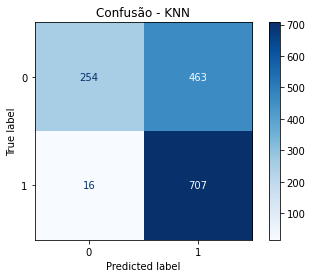

Iteração 0:
	Precisão cross validation:  0.6008583690987125
	Erro absoluto médio cross validation:  0.3402777777777778
Iteração 1:
	Precisão cross validation:  0.5956521739130435
	Erro absoluto médio cross validation:  0.3506944444444444
Iteração 2:
	Precisão cross validation:  0.6063348416289592
	Erro absoluto médio cross validation:  0.3402777777777778
Iteração 3:
	Precisão cross validation:  0.6188340807174888
	Erro absoluto médio cross validation:  0.3159722222222222
Iteração 4:
	Precisão cross validation:  0.6146788990825688
	Erro absoluto médio cross validation:  0.3263888888888889
Matrizes: 


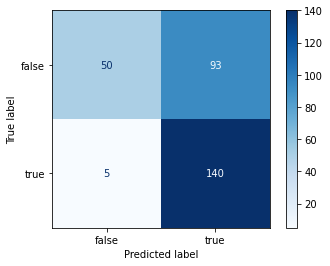

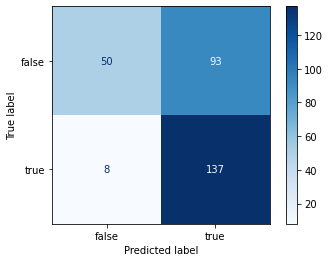

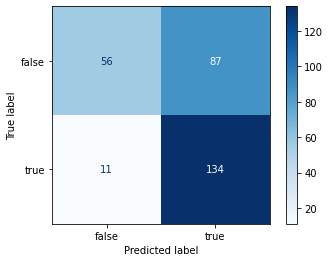

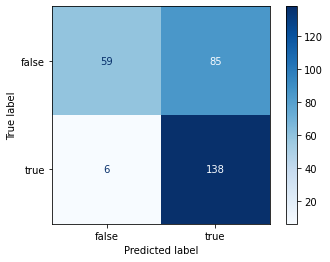

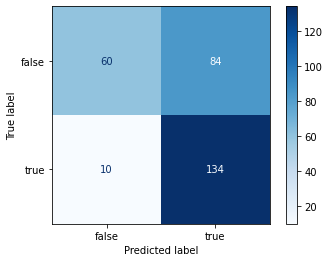

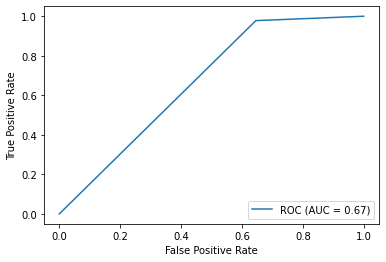

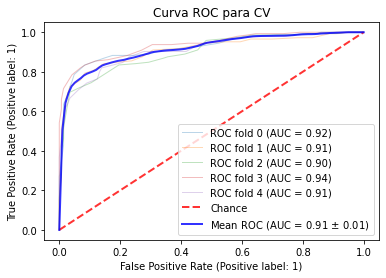

In [26]:
prod_pred_knn = neigh.predict(prod_features_norm)

print_results(prod_pred_knn, neigh,label_prod,prod_features_norm, taxa_base)

resultados_cv(neigh, prod_features_norm, label_prod)

plot_alg_roc(prod_pred_knn, label_prod)

roc_cv(neigh, prod_features_norm, np.array(label_prod), 'knn', True)

## Random Forest

Precisão de produção:  0.9516047382808545
Precisão:  0.9512195121951219
Erro médio absoluto:  0.03958333333333333


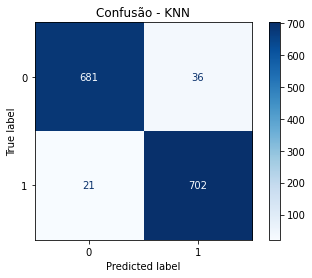

Iteração 0:
	Precisão cross validation:  0.9530201342281879
	Erro absoluto médio cross validation:  0.03819444444444445
Iteração 1:
	Precisão cross validation:  0.9645390070921985
	Erro absoluto médio cross validation:  0.06597222222222222
Iteração 2:
	Precisão cross validation:  0.9712230215827338
	Erro absoluto médio cross validation:  0.052083333333333336
Iteração 3:
	Precisão cross validation:  0.9507042253521126
	Erro absoluto médio cross validation:  0.03819444444444445
Iteração 4:
	Precisão cross validation:  0.9452054794520548
	Erro absoluto médio cross validation:  0.04513888888888889
Matrizes: 


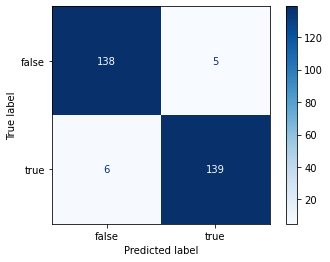

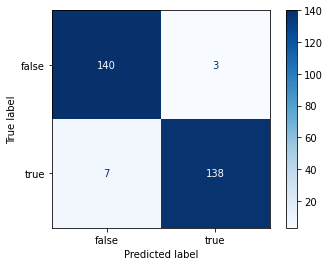

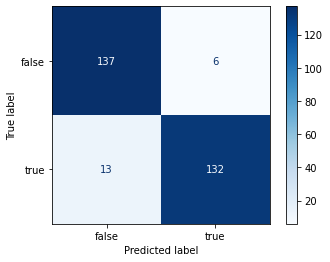

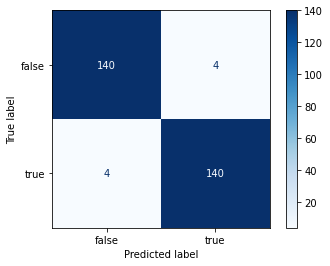

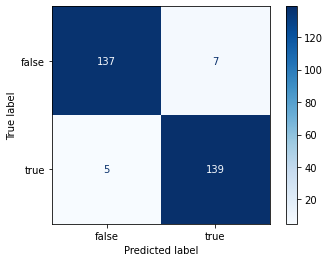

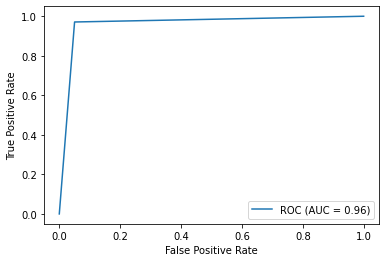

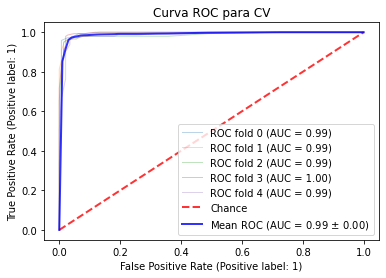

In [27]:
prod_pred_rfc = rfc.predict(prod_features_norm)

print_results(prod_pred_rfc, rfc,label_prod,prod_features_norm, taxa_base)

resultados_cv(rfc, prod_features_norm, label_prod)

plot_alg_roc(prod_pred_rfc, label_prod)

roc_cv(rfc, prod_features_norm, np.array(label_prod), 'rfc', True)

## MLP

Precisão de produção:  0.943381540058209
Precisão:  0.9429347826086957
Erro médio absoluto:  0.049305555555555554


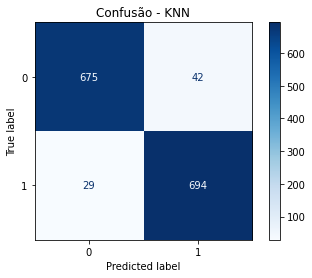

Iteração 0:
	Precisão cross validation:  0.8544303797468354
	Erro absoluto médio cross validation:  0.1111111111111111
Iteração 1:
	Precisão cross validation:  0.8972602739726028
	Erro absoluto médio cross validation:  0.1111111111111111
Iteração 2:
	Precisão cross validation:  0.8375
	Erro absoluto médio cross validation:  0.12152777777777778
Iteração 3:
	Precisão cross validation:  0.9078947368421053
	Erro absoluto médio cross validation:  0.07291666666666667
Iteração 4:
	Precisão cross validation:  0.9194630872483222
	Erro absoluto médio cross validation:  0.0625
Matrizes: 


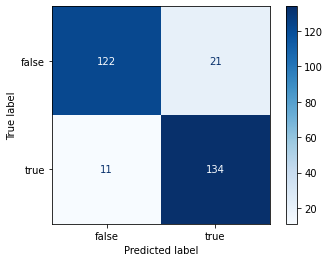

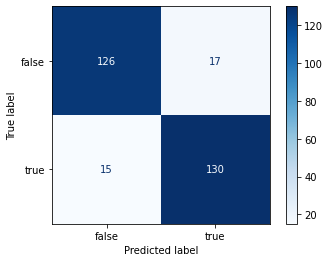

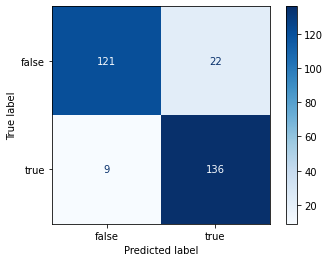

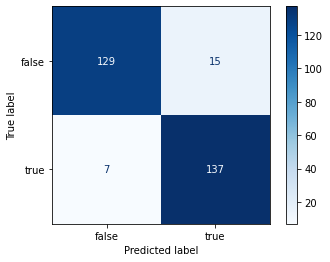

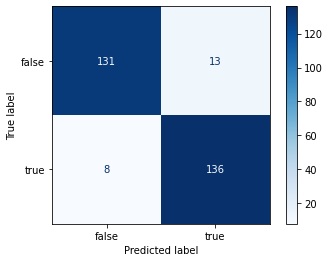

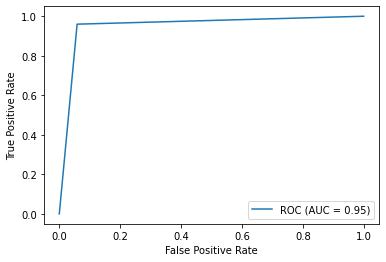

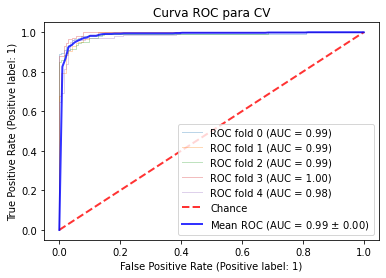

In [28]:
prod_pred_mlp = mlp.predict(prod_features_norm)

print_results(prod_pred_mlp, mlp,label_prod,prod_features_norm, taxa_base)

resultados_cv(mlp, prod_features_norm, label_prod)

plot_alg_roc(prod_pred_mlp, label_prod)

roc_cv(mlp, prod_features_norm, np.array(label_prod), 'mlp', True)

# Referências

Monteiro R.A., Santos R.L.S., Pardo T.A.S., de Almeida T.A., Ruiz E.E.S., Vale O.A. (2018) Contributions to the Study of Fake News in Portuguese: New Corpus and Automatic Detection Results. In: Villavicencio A. et al. (eds) Computational Processing of the Portuguese Language. PROPOR 2018. Lecture Notes in Computer Science, vol 11122. Springer, Cham

https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

Ceschin, F.; Oliveira, L. E. S.; Grégio, A. R. A. Aprendizado de Máquina para Segurança: Algoritmos e Aplicações. Capítulo 2 do Livro de Minicursos do XIX Simpósio Brasileiro de Segurança da Informação e de Sistemas Computacionais, 2019.